In [36]:
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime

import utils.contracts as mc
import matplotlib.pyplot as plt

from pycoingecko import CoinGeckoAPI

Since ctc only provides the block_number as a time feature, we will merge a precomputed dataframe that join dates to block_numbers.

This dataframe is computed by using the evm.async_get_blocks_of_timestamps method from the ctc lib.

In [2]:
### BLOCK NUMBER TO DATE HELPERS ###

df_days = pd.read_parquet("./data/block_to_timestamp.parquet")

def add_dates(df, df_days):
    """
    Merge dates to block_number
    """
    df_comp = pd.merge(df_days.loc[:, ['date', 'block_number']], df, how='right', on='block_number')
    df_comp.drop(columns=['block_number'], inplace=True)
    return df_comp

def fill_dates(df):
    """
    Fill missing dates in df
    """
    dates = pd.date_range(start=df.index.min(),end=df.index.max())
    df_comp = pd.merge(pd.DataFrame({'date':dates}), df, how='left', on='date').set_index('date')
    return df_comp

def preprocess_daily_df(df):
    """
    Process df's dates then group by date (day here)
    """
    df = add_dates(df, df_days)
    df_grp = df.groupby('date').sum()
    df_grp = fill_dates(df_grp).fillna(0)
    return df_grp

In [3]:
### CONST ###

MTA_DECIMALS = 18
STKMTA_DECIMALS = 18
STKBPT_DECIMALS = 18

Because of ctc issues to communicate with etherscan, we were not able to use dex trades and oracle feed price.

We will just get them from the CoinGecko API through the well known pycoingecko lib.

# MTA Price / Volume

In [4]:
cg = CoinGeckoAPI()

In [5]:
metrics = cg.get_coin_market_chart_by_id('meta', 'usd', 365)

df_metrics = pd.DataFrame(data={
                    'date':[datetime.fromtimestamp(i[0]//1000).date() for i in metrics['prices']],
                    'price':[i[1] for i in metrics['prices']],
                    'market_cap':[i[1] for i in metrics['market_caps']],
                    'total_volume':[i[1] for i in metrics['total_volumes']]
                    }).set_index('date')

df_metrics.tail()

price    market_cap   total_volume
date                                             
2022-03-25  0.428315  1.220914e+07  387745.593928
2022-03-26  0.419593  1.205941e+07  256423.040787
2022-03-27  0.413645  1.179918e+07  484257.332638
2022-03-28  0.428740  1.226025e+07  238378.561446
2022-03-29  0.452868  1.291800e+07  586456.545270

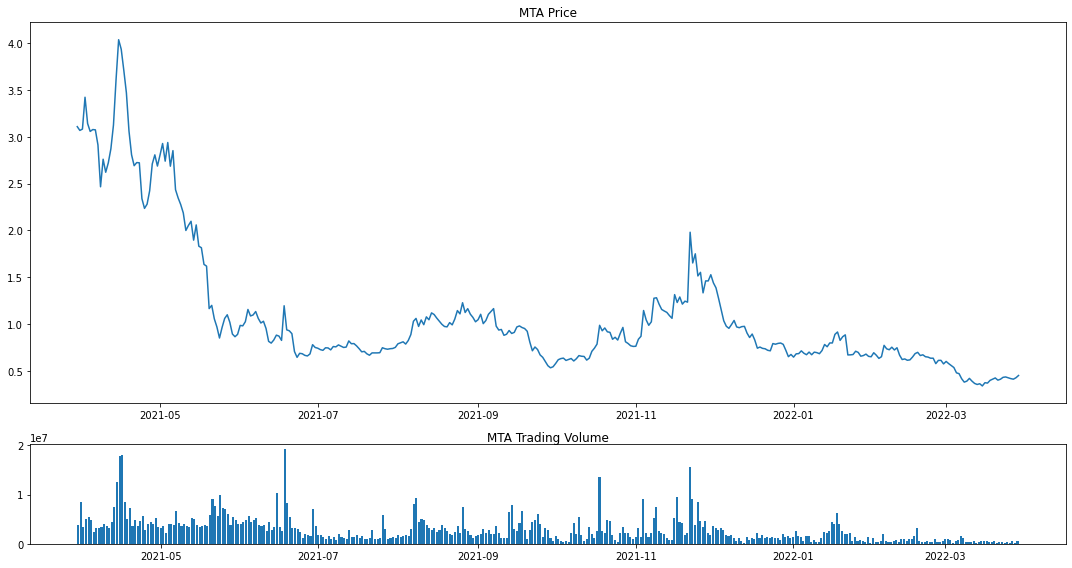

In [6]:
price_plot = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
price_plot.plot(df_metrics.index, df_metrics.price)
plt.title('MTA Price')

volume_plot = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
volume_plot.bar(df_metrics.index, df_metrics.total_volume)
plt.title('MTA Trading Volume', pad=0)

plt.gcf().set_size_inches(15,8)
plt.tight_layout()

# MTA stacked (stkMTA & stkBPT)

In [7]:
# This dataframe will be used in different computation, just a load here

# Load the parquet with all the Transfer events from MTA
df_mta_transfer = pd.read_parquet("./data/mta_transfer.parquet")
df_mta_transfer = df_mta_transfer.reset_index()
df_mta_transfer.head()

block_number  transaction_index  log_index  \
0      10450640                159        153   
1      10450649                222        173   
2      10450649                222        176   
3      10476280                131        164   
4      10476285                187        123   

                                      address  \
0  0xa3bed4e1c75d00fa6f4e5e6922db7261b5e9acd2   
1  0xa3bed4e1c75d00fa6f4e5e6922db7261b5e9acd2   
2  0xa3bed4e1c75d00fa6f4e5e6922db7261b5e9acd2   
3  0xa3bed4e1c75d00fa6f4e5e6922db7261b5e9acd2   
4  0xa3bed4e1c75d00fa6f4e5e6922db7261b5e9acd2   

                                          block_hash  \
0  0x3e8959e9f1b28b7a7e597379bdefa00f8be1f62f2125...   
1  0x7b462b18f27f23c3c44af55f88b04eb5bb1f6dd6da25...   
2  0x7b462b18f27f23c3c44af55f88b04eb5bb1f6dd6da25...   
3  0xb5a0e752fd84e60aaa8d3f72a12f8c0b5bcb6dad7f84...   
4  0x1a58ecaefe536ba4cf2718879f05de9ed01f621d1525...   

                                    transaction_hash  \
0  0x998c0f49c32ecf1bb76378c6ecc92a9ea52ab9a161a3...   
1  0xb5cc04a1eeca79ab540357804b3c76eee7d61a38bb24...   
2  0xb5cc04a1eeca79ab540357804b3c76eee7d61a38bb24...   
3  0x662b71919cc53c617d2d5c600240e6bafcf49beec5b4...   
4  0xd8b4a056f73a7f43eb7faeb31231579bcd02dcee5c5f...   

                             contract_address event_name  \
0  0xa3bed4e1c75d00fa6f4e5e6922db7261b5e9acd2   Transfer   
1  0xa3bed4e1c75d00fa6f4e5e6922db7261b5e9acd2   Transfer   
2  0xa3bed4e1c75d00fa6f4e5e6922db7261b5e9acd2   Transfer   
3  0xa3bed4e1c75d00fa6f4e5e6922db7261b5e9acd2   Transfer   
4  0xa3bed4e1c75d00fa6f4e5e6922db7261b5e9acd2   Transfer   

                                          event_hash  \
0  0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...   
1  0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...   
2  0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...   
3  0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...   
4  0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...   

                                    arg__from  \
0  0x0000000000000000000000000000000000000000   
1  0x19f12c947d25ff8a3b748829d8001ca09a28d46d   
2  0x0a0bbf3d159883bc7c9b6456d6888023a8265aad   
3  0xb8541e73aa47a847fa39e803d19a3f9b1bbc5a6c   
4  0xb8541e73aa47a847fa39e803d19a3f9b1bbc5a6c   

                                      arg__to  arg__amount  
0  0x19f12c947d25ff8a3b748829d8001ca09a28d46d  100000000.0  
1  0x0a0bbf3d159883bc7c9b6456d6888023a8265aad  100000000.0  
2  0xb8541e73aa47a847fa39e803d19a3f9b1bbc5a6c  100000000.0  
3  0x4186c5aed424876f7ebe52f9148552a45e17f287   60000000.0  
4  0xd8bae7d96df905e46718b6cee3410f535e11bf20    5000000.0

## MTA staked in stkMTA (single staking)

In [8]:
# Load the parquet with all the Staked events from stkMTA
df_stkmta_staked = pd.read_parquet("./data/stkmta_staked.parquet")
df_stkmta_staked['stkmta_staked'] = df_stkmta_staked['arg__amount'].astype(float) / pow(10, STKMTA_DECIMALS)
df_stkmta_staked = df_stkmta_staked.reset_index()

# Load the parquet with all the Withdraw events from stkMTA
df_stkmta_withdraw = pd.read_parquet("./data/stkmta_withdraw.parquet")
df_stkmta_withdraw['stkmta_withdraw'] = df_stkmta_withdraw['arg__amount'].astype(float) / pow(10, STKMTA_DECIMALS)
df_stkmta_withdraw = df_stkmta_withdraw.reset_index()

df_stkmta = pd.concat([df_stkmta_staked.loc[:, ['block_number', 'stkmta_staked']],
                     df_stkmta_withdraw.loc[:, ['block_number', 'stkmta_withdraw']]],
                     sort=True).sort_values('block_number').fillna(0)
                      
# add dates and group by day
df_stkmta_grp = preprocess_daily_df(df_stkmta)

# compute total amount of MTA in the vault
df_stkmta_grp['mta_staked'] = (df_stkmta_grp['stkmta_staked'] - df_stkmta_grp['stkmta_withdraw']).cumsum()

df_stkmta_grp.tail()

stkmta_staked  stkmta_withdraw    mta_staked
date                                                    
2022-03-23   77158.629316         0.000000  8.122959e+06
2022-03-24    7407.746241    149323.221712  7.981043e+06
2022-03-25    6222.834346    138000.000000  7.849266e+06
2022-03-26       0.000000         0.000000  7.849266e+06
2022-03-27    9464.055568      4000.000000  7.854730e+06

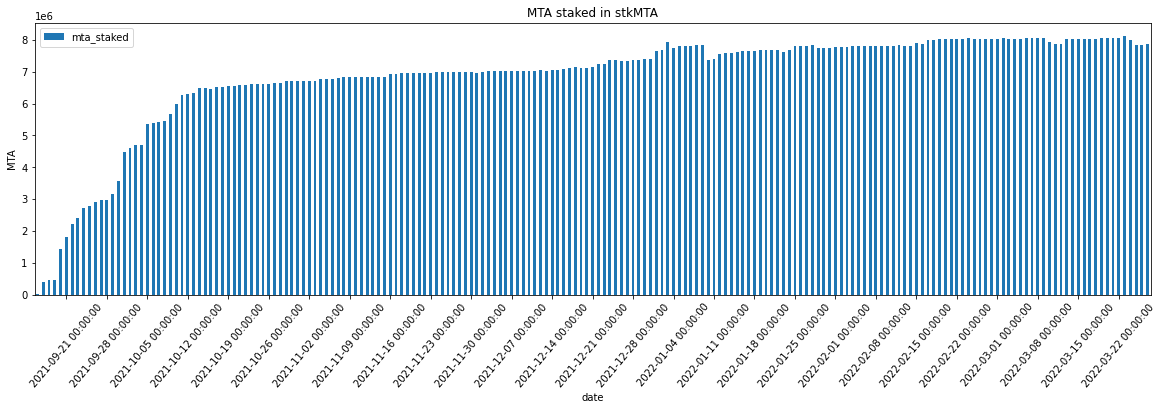

In [9]:
cols = ['mta_staked']

ax = df_stkmta_grp[cols].plot(kind="bar", stacked=True, figsize=(20,5),
                        title="MTA staked in stkMTA", ylabel="MTA", rot=50)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
plt.show()

## MTA staked in mBPT (through the 80/20 MTA/WETH Balancer pool)

To get the amount of MTA deposited in the balancer Pool here, we will use two different mStable' contracts:
- mbpt transfers
- mta transfers

Since mBPT tokens are minted/redeemed when depositing/withdrawing MTA from the pool, we can check that the from/to address of the transfer is the null address.
We can then get the MTA amount deposited/withdrawn from the pool by looking at the MTA transfer occuring in the same transaction than the mint/redeem event.

In [10]:
# Load the parquet with all the Transfer events from mBPT
df_mbpt_transfer = pd.read_parquet("./data/mbpt_transfer.parquet")
df_mbpt_transfer = df_mbpt_transfer.reset_index()
df_mbpt_transfer.head()

block_number  transaction_index  log_index  \
0      13197356                258        256   
1      13197356                258        257   
2      13236090                179        341   
3      13239104                233        304   
4      13239121                 63        125   

                                      address  \
0  0xe2469f47ab58cf9cf59f9822e3c5de4950a41c49   
1  0xe2469f47ab58cf9cf59f9822e3c5de4950a41c49   
2  0xe2469f47ab58cf9cf59f9822e3c5de4950a41c49   
3  0xe2469f47ab58cf9cf59f9822e3c5de4950a41c49   
4  0xe2469f47ab58cf9cf59f9822e3c5de4950a41c49   

                                          block_hash  \
0  0xb8d14e9d778230a0632cf320c6b7d37552730181555b...   
1  0xb8d14e9d778230a0632cf320c6b7d37552730181555b...   
2  0x3e79c9b8ec6c7a6f76df599281c021fb7723c7242e12...   
3  0x20173189641bee34d6ac8781eb6026353dbf78edc8f0...   
4  0xba7c3cd359fcf2dc9ba4f675af02747a613a062ac551...   

                                    transaction_hash  \
0  0x5c7ba467a79b3fb53cb9adb74868e82c8e4dde7e9c67...   
1  0x5c7ba467a79b3fb53cb9adb74868e82c8e4dde7e9c67...   
2  0x04db30c74d4e6a0c759affdba9dd39fb3a2a26871180...   
3  0x0a9e44e2fd4a079ca488ba354e86083523c9633fa76a...   
4  0x79464275c0e5f69cc77b9d9e8ca0b29b168d0c308d67...   

                             contract_address event_name  \
0  0xe2469f47ab58cf9cf59f9822e3c5de4950a41c49   Transfer   
1  0xe2469f47ab58cf9cf59f9822e3c5de4950a41c49   Transfer   
2  0xe2469f47ab58cf9cf59f9822e3c5de4950a41c49   Transfer   
3  0xe2469f47ab58cf9cf59f9822e3c5de4950a41c49   Transfer   
4  0xe2469f47ab58cf9cf59f9822e3c5de4950a41c49   Transfer   

                                          event_hash  \
0  0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...   
1  0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...   
2  0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...   
3  0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...   
4  0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...   

                                    arg__from  \
0  0x0000000000000000000000000000000000000000   
1  0x0000000000000000000000000000000000000000   
2  0x19f12c947d25ff8a3b748829d8001ca09a28d46d   
3  0x0000000000000000000000000000000000000000   
4  0x299a7db82536cd965424213f85ebbf0dbf4eda5f   

                                      arg__to   arg__amount  
0  0x0000000000000000000000000000000000000000  1.000000e-12  
1  0x19f12c947d25ff8a3b748829d8001ca09a28d46d  3.985473e+03  
2  0xefbe22085d9f29863cfb77eed16d3cc0d927b011  1.000000e+03  
3  0x299a7db82536cd965424213f85ebbf0dbf4eda5f  3.152915e+01  
4  0xefbe22085d9f29863cfb77eed16d3cc0d927b011  3.152915e+01

In [11]:
### MTA transfered to BAL vault during mBPT mint events ###
# select transfer concerning mBPT mint event
df_mbpt_mint = df_mbpt_transfer.loc[(df_mbpt_transfer.arg__from == mc.null_address) & 
                                    (df_mbpt_transfer.arg__to != mc.null_address),
                                        ['block_number', 'transaction_hash', 'arg__to']]

# select transfers mta to bal vault 
df_mta_to_bal_vault = df_mta_transfer.loc[(df_mta_transfer.arg__to == mc.balancer_vault),
                    ['transaction_hash', 'arg__amount', 'arg__from']]

# merge on transaction_hash and arg__to/arg__from(receive the mBPT, send the MTA)
df_mta_stk_mta_bal = pd.merge(df_mbpt_mint, df_mta_to_bal_vault,
                              how='left', left_on=['transaction_hash', 'arg__to'], 
                              right_on=['transaction_hash', 'arg__from'])\
                        .loc[:, ['block_number', 'arg__amount']].rename(columns={'arg__amount':'mta_deposited'})


### MTA transfered from BAL vault during mBPT redeem events ###
# select transfer concerning mBPT redeem event
df_mbpt_redeem = df_mbpt_transfer.loc[(df_mbpt_transfer.arg__to == mc.null_address) & 
                                    (df_mbpt_transfer.arg__from != mc.null_address),
                                        ['block_number', 'transaction_hash', 'arg__from']]

# select transfers mta from bal vault 
df_mta_from_bal_vault = df_mta_transfer.loc[(df_mta_transfer.arg__from == mc.balancer_vault),
                    ['transaction_hash', 'arg__amount', 'arg__to']]

# merge on transaction_hash and arg__from/arg__to(receive the MTA, send the mBPT)
df_mta_with_mta_bal = pd.merge(df_mbpt_redeem, df_mta_from_bal_vault,
                              how='left', left_on=['transaction_hash', 'arg__from'], 
                              right_on=['transaction_hash', 'arg__to'])\
                        .loc[:, ['block_number', 'arg__amount']].rename(columns={'arg__amount':'mta_withdrawn'})

# concat MTA deposits & withdraws from the pool 
df_mta_bal = pd.concat([df_mta_stk_mta_bal, df_mta_with_mta_bal]).fillna(0).sort_values('block_number')

# add dates and group by day
df_mta_bal_grp = preprocess_daily_df(df_mta_bal)

# compute total 
df_mta_bal_grp['mta_mbpt_staked'] = (df_mta_bal_grp['mta_deposited'] - df_mta_bal_grp['mta_withdrawn']).cumsum()

df_mta_bal_grp.tail()

mta_deposited  mta_withdrawn  mta_mbpt_staked
date                                                     
2022-03-24        0.00000            0.0     3.005198e+06
2022-03-25        0.00000            0.0     3.005198e+06
2022-03-26        0.00000            0.0     3.005198e+06
2022-03-27        0.00000            0.0     3.005198e+06
2022-03-28     5212.54439            0.0     3.010411e+06

We can now compute the overall amount of MTA staked accross stkMTA and mBPT.

In [12]:
df_mta_staked_total = pd.concat([df_mta_bal_grp.loc[:, 'mta_mbpt_staked'], df_stkmta_grp.loc[:, 'mta_staked']], axis=1)\
                        .fillna(0)

df_mta_staked_total['total_mta_staked'] = df_mta_staked_total['mta_mbpt_staked'] + df_mta_staked_total['mta_staked']

df_mta_staked_total.tail()

mta_mbpt_staked    mta_staked  total_mta_staked
date                                                       
2022-03-24     3.005198e+06  7.981043e+06      1.098624e+07
2022-03-25     3.005198e+06  7.849266e+06      1.085446e+07
2022-03-26     3.005198e+06  7.849266e+06      1.085446e+07
2022-03-27     3.005198e+06  7.854730e+06      1.085993e+07
2022-03-28     3.010411e+06  0.000000e+00      3.010411e+06

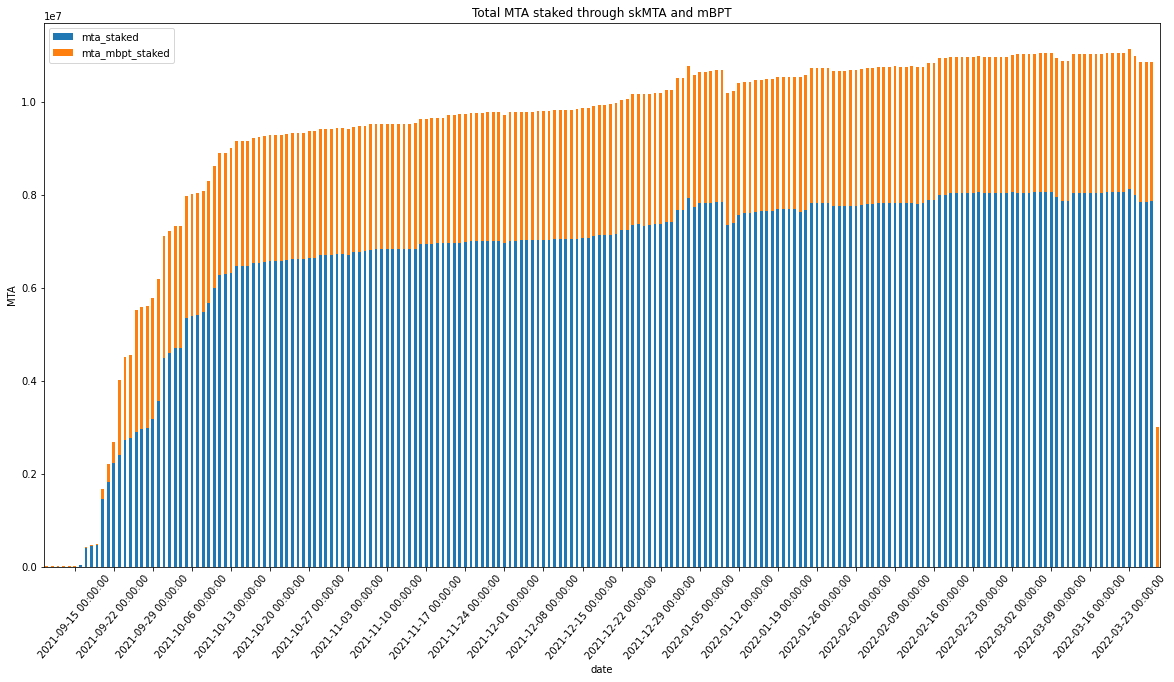

In [13]:
cols = ['mta_staked', 'mta_mbpt_staked']

ax = df_mta_staked_total[cols].plot(kind="bar", stacked=True, figsize=(20,10),
                        title="Total MTA staked through skMTA and mBPT", ylabel="MTA", rot=50)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
plt.show()

Now we have computed the MTA amount staked across stkMTA and mBPT, we would like to know the MTA amount benifiting from incentives.
To do so, we have to compute the amount of MTA exposed to MTA farming through stkBPT also, stkMTA is trivial.

Moreover, this computation combines different mStable' contracts/events and will be an interesting exploration.


- Compute mBPT supply over time
- Compute mBPT staked in stkBPT over time
- Compute mBPT staked ratio over time
- Finally, apply this ratio to the MTA staked in Balancer LP previously computed

This way, we will know the amount of MTA benefiting from MTA incentives through stkBPT.

## mBPT supply

In [14]:
# select transfer concerning mint/burn events
df_mbpt_mint_burn = df_mbpt_transfer.loc[(df_mbpt_transfer.arg__from == mc.null_address) ^
                                           (df_mbpt_transfer.arg__to == mc.null_address),
                                        :].copy()

df_mbpt_mint_burn.loc[df_mbpt_mint_burn.arg__to == mc.null_address, 
              'mbpt_burn'] = df_mbpt_mint_burn.loc[df_mbpt_mint_burn.arg__to == mc.null_address, 'arg__amount']
df_mbpt_mint_burn.loc[df_mbpt_mint_burn.arg__from == mc.null_address, 
              'mbpt_mint'] = df_mbpt_mint_burn.loc[df_mbpt_mint_burn.arg__from == mc.null_address, 'arg__amount']

df_mbpt_temp = df_mbpt_mint_burn.copy()
df_mbpt_mint_burn = df_mbpt_mint_burn[['block_number', 'mbpt_burn', 
                                       'mbpt_mint', 'transaction_hash']].fillna(0).reset_index(drop=True)

# add dates and group by day
df_mbpt_mint_burn_grp = preprocess_daily_df(df_mbpt_mint_burn)

df_mbpt_mint_burn_grp['mbpt_supply'] = (df_mbpt_mint_burn_grp['mbpt_mint'] - df_mbpt_mint_burn_grp['mbpt_burn']).cumsum()

df_mbpt_mint_burn_grp.tail()

mbpt_burn    mbpt_mint    mbpt_supply
date                                             
2022-03-24        0.0     0.000000  820447.554860
2022-03-25        0.0     0.000000  820447.554860
2022-03-26        0.0     0.000000  820447.554860
2022-03-27        0.0     0.000000  820447.554860
2022-03-28        0.0  1028.171605  821475.726465

## mBPT staked in stkBPT (Balancer LP)

In [15]:
# Load the parquet with all the Staked events from stkBPT
df_stkbpt_staked = pd.read_parquet("./data/stkbpt_staked.parquet")
df_stkbpt_staked['stkbpt_staked'] = df_stkbpt_staked['arg__amount'].astype(float) / pow(10, STKBPT_DECIMALS)
df_stkbpt_staked = df_stkbpt_staked.reset_index()

# Load the parquet with all the Withdraw events from stkBPT
df_stkbpt_withdraw = pd.read_parquet("./data/stkbpt_withdraw.parquet")
df_stkbpt_withdraw['stkbpt_withdraw'] = df_stkbpt_withdraw['arg__amount'].astype(float) / pow(10, STKBPT_DECIMALS)
df_stkbpt_withdraw = df_stkbpt_withdraw.reset_index()

df_stkbpt = pd.concat([df_stkbpt_staked.loc[:, ['block_number', 'stkbpt_staked']],
                     df_stkbpt_withdraw.loc[:, ['block_number', 'stkbpt_withdraw']]],
                     sort=True).sort_values('block_number').fillna(0)
                      
# add dates and group by day
df_stkbpt_grp = preprocess_daily_df(df_stkbpt)

# compute total amount of BPT in the vault
df_stkbpt_grp['mbpt_staked'] = (df_stkbpt_grp['stkbpt_staked'] - df_stkbpt_grp['stkbpt_withdraw']).cumsum()

df_stkbpt_grp.tail()

stkbpt_staked  stkbpt_withdraw    mbpt_staked
date                                                     
2022-03-24       0.000000              0.0  799784.202647
2022-03-25       0.000000              0.0  799784.202647
2022-03-26       0.000000              0.0  799784.202647
2022-03-27       0.000000              0.0  799784.202647
2022-03-28    1028.171605              0.0  800812.374252

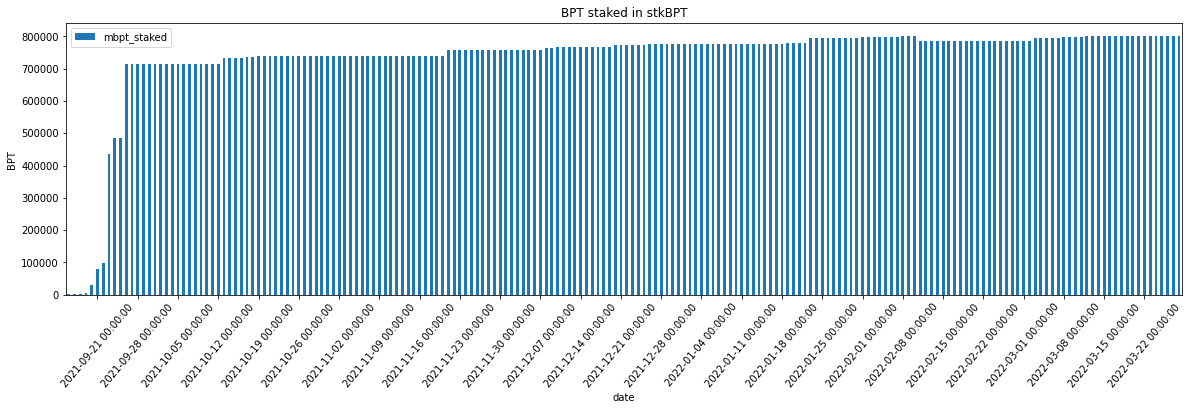

In [16]:
cols = ['mbpt_staked']

ax = df_stkbpt_grp[cols].plot(kind="bar", stacked=True, figsize=(20,5),
                        title="BPT staked in stkBPT", ylabel="BPT", rot=50)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
plt.show()

## mBPT staked in stkBPT ratio

In [17]:
df_mbpt_stk_ratio = pd.concat([df_mbpt_mint_burn_grp.loc[:, 'mbpt_supply'], df_stkbpt_grp.loc[:, 'mbpt_staked']], axis=1)\
                        .fillna(0)

df_mbpt_stk_ratio['mBPT_staked_ratio'] = df_mbpt_stk_ratio['mbpt_staked'] / df_mbpt_stk_ratio['mbpt_supply']

df_mbpt_stk_ratio.tail()

mbpt_supply    mbpt_staked  mBPT_staked_ratio
date                                                       
2022-03-24  820447.554860  799784.202647           0.974815
2022-03-25  820447.554860  799784.202647           0.974815
2022-03-26  820447.554860  799784.202647           0.974815
2022-03-27  820447.554860  799784.202647           0.974815
2022-03-28  821475.726465  800812.374252           0.974846

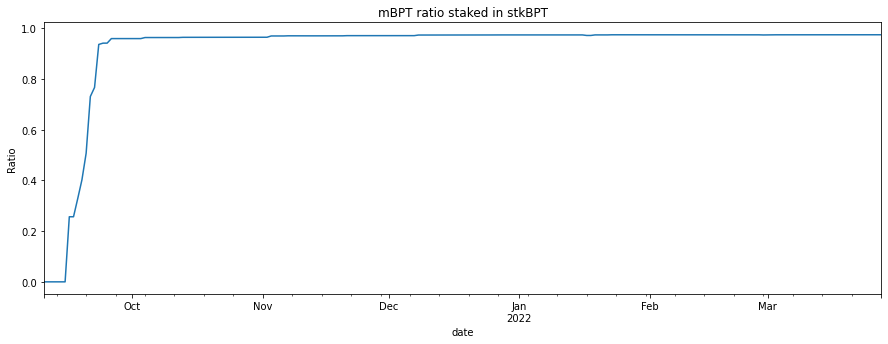

In [18]:
df_mbpt_stk_ratio.mBPT_staked_ratio.plot(figsize=(15,5), ylabel="Ratio")
plt.title("mBPT ratio staked in stkBPT")
plt.show()

## MTA benefiting from incentives through stkBPT

In [19]:
df_mbpt_mta_stk = pd.concat([df_mbpt_stk_ratio.loc[:, 'mBPT_staked_ratio'], df_mta_bal_grp.loc[:, 'mta_mbpt_staked']], axis=1)\
                        .fillna(0)

df_mbpt_mta_stk['mBPT_mta_staked'] = df_mbpt_mta_stk['mBPT_staked_ratio'] * df_mbpt_mta_stk['mta_mbpt_staked']

df_mbpt_mta_stk.tail()

mBPT_staked_ratio  mta_mbpt_staked  mBPT_mta_staked
date                                                           
2022-03-24           0.974815     3.005198e+06     2.929511e+06
2022-03-25           0.974815     3.005198e+06     2.929511e+06
2022-03-26           0.974815     3.005198e+06     2.929511e+06
2022-03-27           0.974815     3.005198e+06     2.929511e+06
2022-03-28           0.974846     3.010411e+06     2.934687e+06

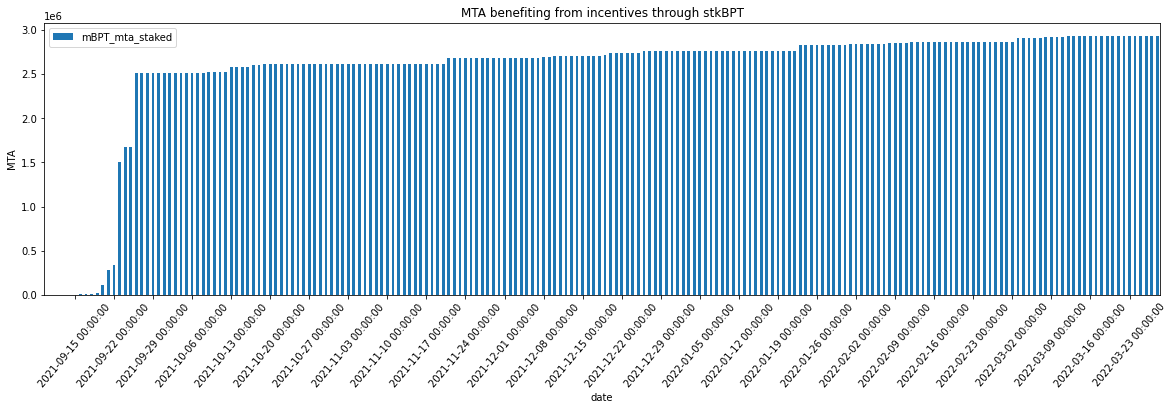

In [20]:
cols = ['mBPT_mta_staked']

ax = df_mbpt_mta_stk[cols].plot(kind="bar", stacked=True, figsize=(20,5),
                        title="MTA benefiting from incentives through stkBPT", ylabel="MTA", rot=50)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
plt.show()

## Total MTA benefiting from incentives (through stkMTA and stkBPT)

In [21]:
df_total_mta_stk = pd.concat([df_stkmta_grp.loc[:, 'mta_staked'], df_mbpt_mta_stk.loc[:, 'mBPT_mta_staked']], axis=1)\
                        .fillna(0)

df_total_mta_stk['total_mta_staked'] = df_total_mta_stk['mta_staked'] + df_total_mta_stk['mBPT_mta_staked']

df_total_mta_stk.tail()

mta_staked  mBPT_mta_staked  total_mta_staked
date                                                       
2022-03-24  7.981043e+06     2.929511e+06      1.091055e+07
2022-03-25  7.849266e+06     2.929511e+06      1.077878e+07
2022-03-26  7.849266e+06     2.929511e+06      1.077878e+07
2022-03-27  7.854730e+06     2.929511e+06      1.078424e+07
2022-03-28  0.000000e+00     2.934687e+06      2.934687e+06

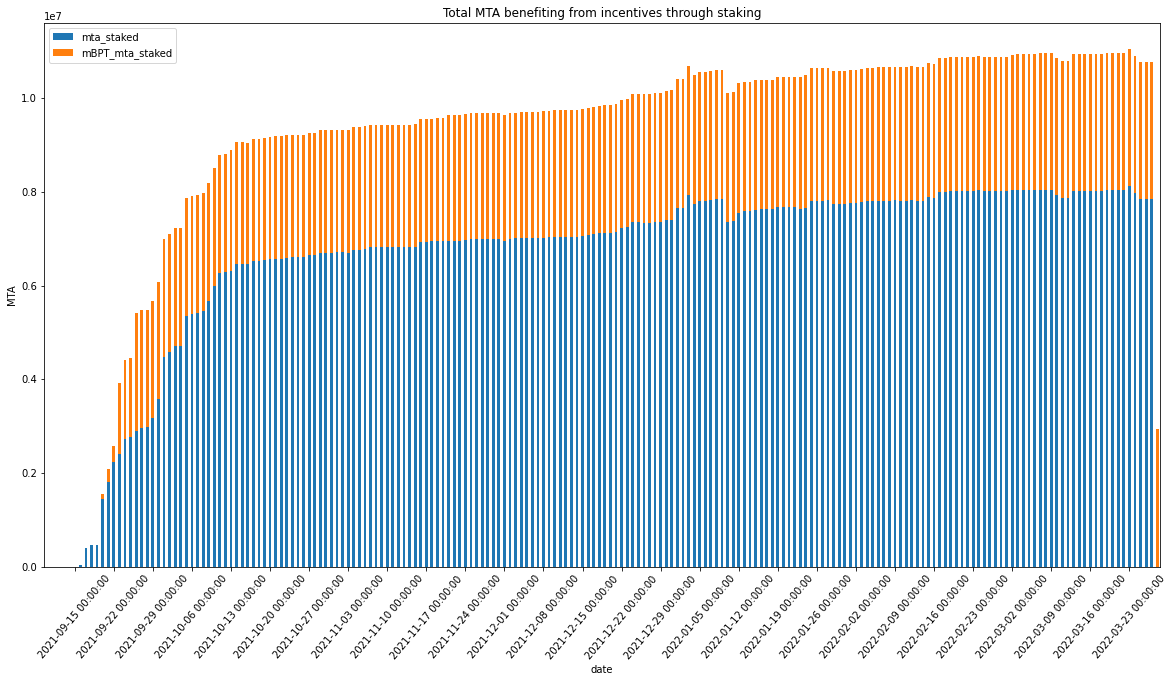

In [22]:
cols = ['mta_staked', 'mBPT_mta_staked']

ax = df_total_mta_stk[cols].plot(kind="bar", stacked=True, figsize=(20,10),
                        title="Total MTA benefiting from incentives through staking", ylabel="MTA", rot=50)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
plt.show()

We will now have a look at the MTA placed in the different mStable products, Save Vaults & Feeder Pools.

## MTA in Save Vaults

In [23]:
# helpers
vaults = [mc.imUSD_vault , mc.imBTC_vault, 
          mc.mUSD_GUSD_vault, mc.mUSD_BUSD_vault, mc.mUSD_alUSD_vault, mc.mUSD_RAI_vault, mc.mUSD_FEI_vault, 
          mc.mBTC_HBTC_vault, mc.mBTC_tBTC_v1_vault, mc.mBTC_tBTC_v2_vault]

tag_name = ['imUSD', 'imBTC',
            'fGUSD', 'fBUSD', 'falUSD', 'fRAI', 'fFEI',
            'fHBTC', 'ftBTC_v1', 'ftBTC_v2']

In [24]:
# select transfers concerning Vaults
df_vaults = df_mta_transfer.loc[(df_mta_transfer.arg__from.isin(vaults)) |
                   (df_mta_transfer.arg__to.isin(vaults)),
                ['block_number', 'arg__from', 'arg__to', 'arg__amount']]

# create deposit and withdraw columns for each vault
for vault, name in zip(vaults, tag_name):
    df_vaults.loc[df_vaults.arg__to == vault, 
              f'{name}_deposit'] = df_vaults.loc[df_vaults.arg__to == vault, 'arg__amount']
    df_vaults.loc[df_vaults.arg__from == vault, 
              f'{name}_withdraw'] = df_vaults.loc[df_vaults.arg__from == vault, 'arg__amount']

df_vaults = df_vaults.drop(columns=['arg__amount' ,'arg__from', 'arg__to']).fillna(0).reset_index(drop=True)


# add dates and group by day
df_vaults_grp = preprocess_daily_df(df_vaults)

# compute total amount of MTA in each vault
for name in tag_name:
    df_vaults_grp[f'{name}_total'] = (df_vaults_grp[f'{name}_deposit'] - df_vaults_grp[f'{name}_withdraw']).cumsum()
    
df_vaults_grp.tail(5)

imUSD_deposit  imUSD_withdraw  imBTC_deposit  imBTC_withdraw  \
date                                                                       
2022-03-24    11554.11525     2268.476039    5704.098569        0.000000   
2022-03-25        0.00000       71.363670       0.000000        0.000000   
2022-03-26        0.00000       39.503679       0.000000     2210.076546   
2022-03-27        0.00000     7947.282425       0.000000        0.000000   
2022-03-28        0.00000        0.000000       0.000000        0.000000   

            fGUSD_deposit  fGUSD_withdraw  fBUSD_deposit  fBUSD_withdraw  \
date                                                                       
2022-03-24     972.654179     2485.753661    5182.842699        0.000000   
2022-03-25       0.000000     2995.763980       0.000000        0.000000   
2022-03-26       0.000000        0.000000       0.000000      574.647032   
2022-03-27       0.000000        0.000000       0.000000        0.000000   
2022-03-28       0.000000     1652.101166       0.000000        0.000000   

            falUSD_deposit  falUSD_withdraw  ...    imUSD_total  \
date                                         ...                  
2022-03-24      181.981345              0.0  ...  717851.138833   
2022-03-25        0.000000              0.0  ...  717779.775163   
2022-03-26        0.000000              0.0  ...  717740.271484   
2022-03-27        0.000000              0.0  ...  709792.989059   
2022-03-28        0.000000              0.0  ...  709792.989059   

              imBTC_total    fGUSD_total    fBUSD_total   falUSD_total  \
date                                                                     
2022-03-24  184254.793136  442272.520866  605391.204031  144494.423775   
2022-03-25  184254.793136  439276.756886  605391.204031  144494.423775   
2022-03-26  182044.716590  439276.756886  604816.556999  144494.423775   
2022-03-27  182044.716590  439276.756886  604816.556999  144494.423775   
2022-03-28  182044.716590  437624.655720  604816.556999  144494.423775   

            fRAI_total  fFEI_total    fHBTC_total  ftBTC_v1_total  \
date                                                                
2022-03-24         0.0         0.0  324485.837826   185993.657340   
2022-03-25         0.0         0.0  324485.837826   178364.760317   
2022-03-26         0.0         0.0  321280.600230   174550.663887   
2022-03-27         0.0         0.0  320007.097139   173363.336620   
2022-03-28         0.0         0.0  320007.097139   173363.336620   

            ftBTC_v2_total  
date                        
2022-03-24    54507.425331  
2022-03-25    54507.425331  
2022-03-26    54507.425331  
2022-03-27    54507.425331  
2022-03-28    54507.425331  

[5 rows x 30 columns]

### MTA in mAsset Vaults

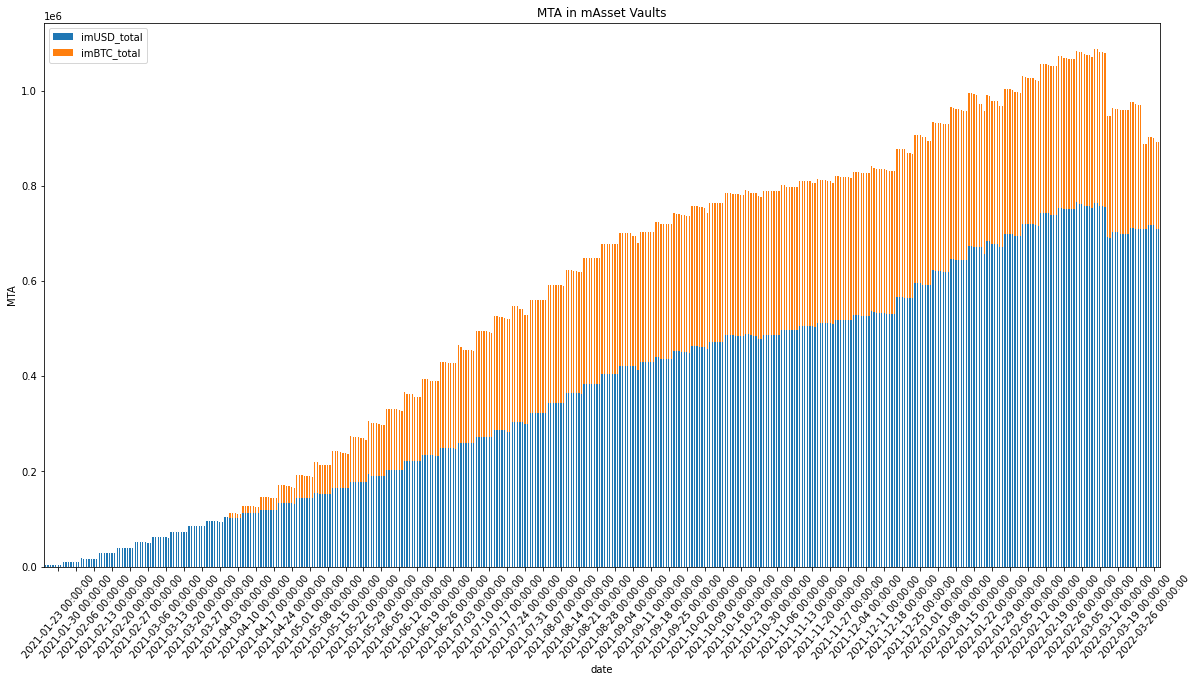

In [25]:
cols = ['imUSD_total', 'imBTC_total']

ax = df_vaults_grp[cols].plot(kind="bar", stacked=True, figsize=(20,10),
                        title="MTA in mAsset Vaults", ylabel="MTA", rot=50)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
plt.show()

### MTA in Feeder Pools Vaults

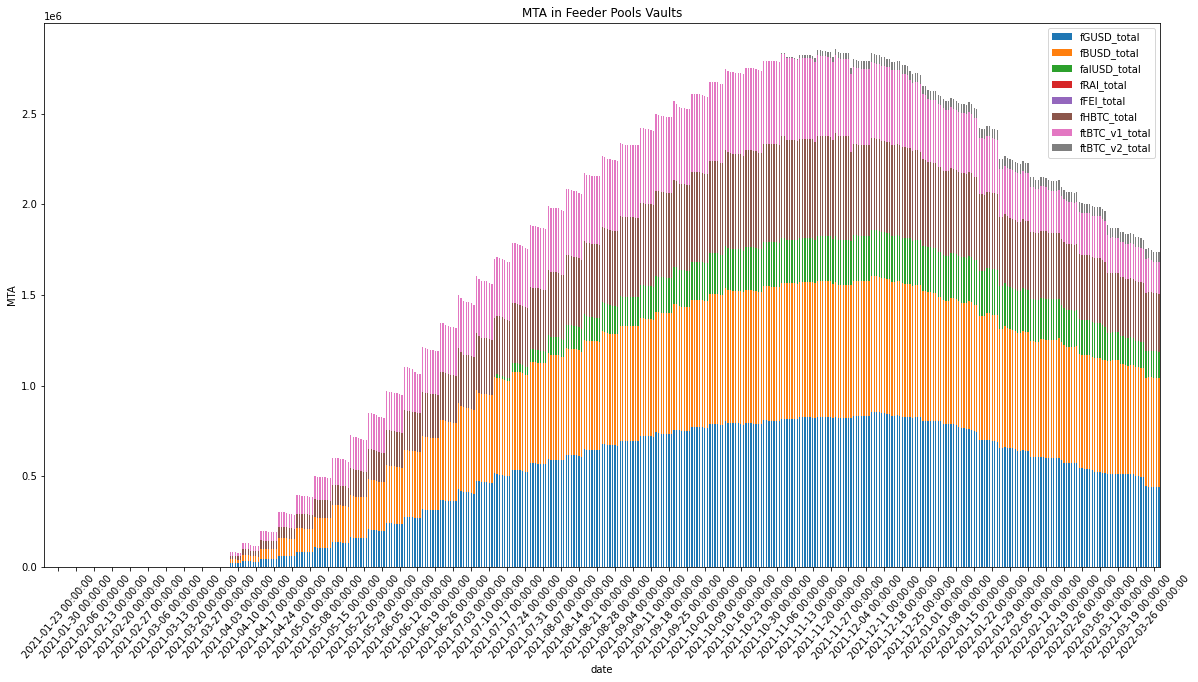

In [26]:
cols = [col_title for col_title in df_vaults_grp.columns if (col_title.endswith('total') and 
                                                             col_title not in ['imUSD_total', 'imBTC_total'])]

ax = df_vaults_grp[cols].plot(kind="bar", stacked=True, figsize=(20,10),
                        title="MTA in Feeder Pools Vaults", ylabel="MTA", rot=50)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
plt.show()

### MTA in mAsset & Feeder Pools Vaults

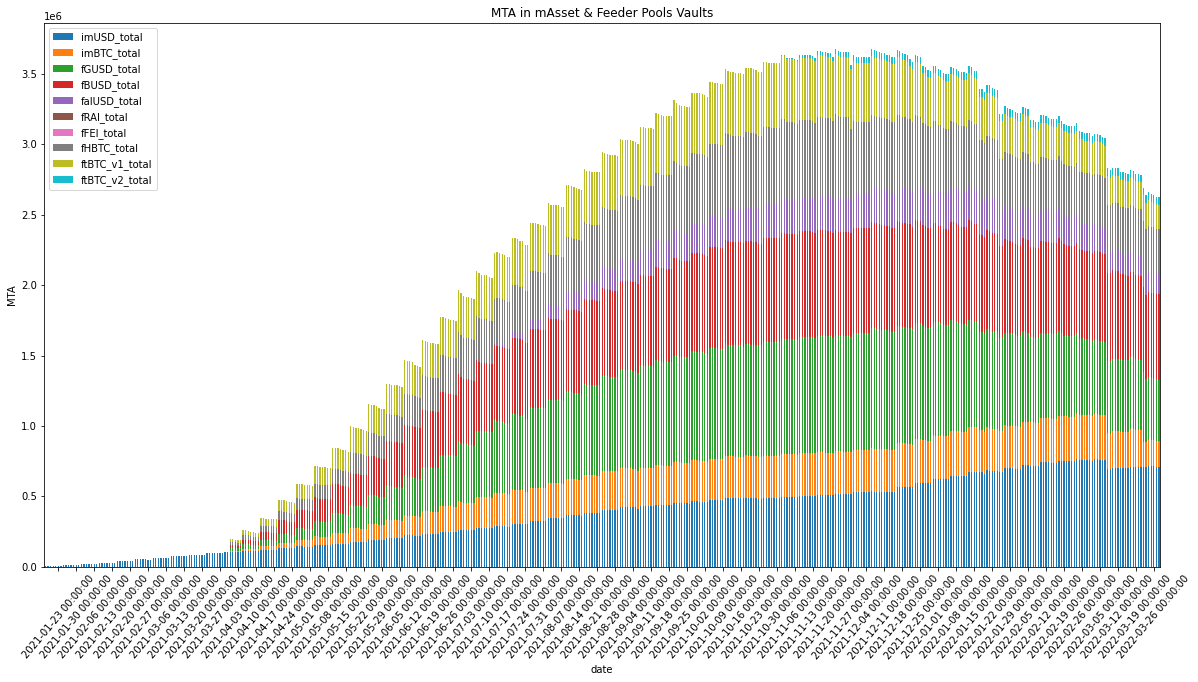

In [27]:
total_cols = [col_title for col_title in df_vaults_grp.columns if col_title.endswith('total')]

ax = df_vaults_grp[total_cols].plot(kind="bar", stacked=True, figsize=(20,10),
                        title="MTA in mAsset & Feeder Pools Vaults", ylabel="MTA", rot=50)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
plt.show()

# MTA distributed by the Emissions Controller

In [28]:
# Load the parquet with all the DistributedReward events from the Emissions Controller
df_ec = pd.read_parquet("./data/emissions_controller_dist_rewards.parquet")
df_ec['arg__amount'] = df_ec['arg__amount'].astype(float) / pow(10, MTA_DECIMALS)
df_ec = df_ec.reset_index()
df_ec.head()

block_number  transaction_index  log_index  \
0      13813020                 36         74   
1      13813020                 36         77   
2      13813020                 36         80   
3      13813020                 36         83   
4      13813020                 36         86   

                                      address  \
0  0xba69e6fc7df49a3b75b565068fb91ff2d9d91780   
1  0xba69e6fc7df49a3b75b565068fb91ff2d9d91780   
2  0xba69e6fc7df49a3b75b565068fb91ff2d9d91780   
3  0xba69e6fc7df49a3b75b565068fb91ff2d9d91780   
4  0xba69e6fc7df49a3b75b565068fb91ff2d9d91780   

                                          block_hash  \
0  0xe38281ef5d4e8ccc91fb80b3eb7ee7dbd32431e5c7d7...   
1  0xe38281ef5d4e8ccc91fb80b3eb7ee7dbd32431e5c7d7...   
2  0xe38281ef5d4e8ccc91fb80b3eb7ee7dbd32431e5c7d7...   
3  0xe38281ef5d4e8ccc91fb80b3eb7ee7dbd32431e5c7d7...   
4  0xe38281ef5d4e8ccc91fb80b3eb7ee7dbd32431e5c7d7...   

                                    transaction_hash  \
0  0x7c736bebce4dc6394a4e94d23c51cbfbaafcfdf5019b...   
1  0x7c736bebce4dc6394a4e94d23c51cbfbaafcfdf5019b...   
2  0x7c736bebce4dc6394a4e94d23c51cbfbaafcfdf5019b...   
3  0x7c736bebce4dc6394a4e94d23c51cbfbaafcfdf5019b...   
4  0x7c736bebce4dc6394a4e94d23c51cbfbaafcfdf5019b...   

                             contract_address         event_name  \
0  0xba69e6fc7df49a3b75b565068fb91ff2d9d91780  DistributedReward   
1  0xba69e6fc7df49a3b75b565068fb91ff2d9d91780  DistributedReward   
2  0xba69e6fc7df49a3b75b565068fb91ff2d9d91780  DistributedReward   
3  0xba69e6fc7df49a3b75b565068fb91ff2d9d91780  DistributedReward   
4  0xba69e6fc7df49a3b75b565068fb91ff2d9d91780  DistributedReward   

                                          event_hash  arg__dialId  \
0  0x6f6d7802368c6a384bce8b9b0752080d37d6fe3f2782...            2   
1  0x6f6d7802368c6a384bce8b9b0752080d37d6fe3f2782...            3   
2  0x6f6d7802368c6a384bce8b9b0752080d37d6fe3f2782...            4   
3  0x6f6d7802368c6a384bce8b9b0752080d37d6fe3f2782...            5   
4  0x6f6d7802368c6a384bce8b9b0752080d37d6fe3f2782...            6   

    arg__amount  
0  35548.646733  
1  11286.831032  
2   3239.920878  
3   8143.875712  
4    362.635370

To maximize further automation and on-chain data usage, we can use the AddedDial event and just update a 
dict(key:arg__recipient, value:'project_name')

In [29]:
# to maximize further automation and on-chain data usage, we can use the AddedDial event
# and just update a dict(key:arg__recipient, value:'project_name')
df_add_dial = pd.read_parquet("./data/emissions_controller_added_dial.parquet")
df_add_dial = df_add_dial.reset_index()
df_add_dial.head()

block_number  transaction_index  log_index  \
0      13761579                 37         70   
1      13761579                 37         71   
2      13761579                 37         72   
3      13761579                 37         73   
4      13761579                 37         74   

                                      address  \
0  0xba69e6fc7df49a3b75b565068fb91ff2d9d91780   
1  0xba69e6fc7df49a3b75b565068fb91ff2d9d91780   
2  0xba69e6fc7df49a3b75b565068fb91ff2d9d91780   
3  0xba69e6fc7df49a3b75b565068fb91ff2d9d91780   
4  0xba69e6fc7df49a3b75b565068fb91ff2d9d91780   

                                          block_hash  \
0  0x092be48b878fc8b609f75498cb690489885d7ced7897...   
1  0x092be48b878fc8b609f75498cb690489885d7ced7897...   
2  0x092be48b878fc8b609f75498cb690489885d7ced7897...   
3  0x092be48b878fc8b609f75498cb690489885d7ced7897...   
4  0x092be48b878fc8b609f75498cb690489885d7ced7897...   

                                    transaction_hash  \
0  0x9a2cfb4d6e0b62d8021c7c347fd5b8e1d5073b67cd71...   
1  0x9a2cfb4d6e0b62d8021c7c347fd5b8e1d5073b67cd71...   
2  0x9a2cfb4d6e0b62d8021c7c347fd5b8e1d5073b67cd71...   
3  0x9a2cfb4d6e0b62d8021c7c347fd5b8e1d5073b67cd71...   
4  0x9a2cfb4d6e0b62d8021c7c347fd5b8e1d5073b67cd71...   

                             contract_address event_name  \
0  0xba69e6fc7df49a3b75b565068fb91ff2d9d91780  AddedDial   
1  0xba69e6fc7df49a3b75b565068fb91ff2d9d91780  AddedDial   
2  0xba69e6fc7df49a3b75b565068fb91ff2d9d91780  AddedDial   
3  0xba69e6fc7df49a3b75b565068fb91ff2d9d91780  AddedDial   
4  0xba69e6fc7df49a3b75b565068fb91ff2d9d91780  AddedDial   

                                          event_hash  arg__dialId  \
0  0xb9f0716ef5e01dbdaef953d36354c0ddbbddc575f690...            0   
1  0xb9f0716ef5e01dbdaef953d36354c0ddbbddc575f690...            1   
2  0xb9f0716ef5e01dbdaef953d36354c0ddbbddc575f690...            2   
3  0xb9f0716ef5e01dbdaef953d36354c0ddbbddc575f690...            3   
4  0xb9f0716ef5e01dbdaef953d36354c0ddbbddc575f690...            4   

                               arg__recipient  
0  0x8f2326316ec696f6d023e37a9931c2b2c177a3d7  
1  0xefbe22085d9f29863cfb77eed16d3cc0d927b011  
2  0x78befca7de27d07dc6e71da295cc2946681a6c7b  
3  0xf38522f63f40f9dd81abafd2b8efc2ec958a3016  
4  0xadeedd3e5768f7882572ad91065f93ba88343c99

In [30]:
dials_dict = {
    '0x8f2326316ec696f6d023e37a9931c2b2c177a3d7': 'Staked MTA V2',
    '0xefbe22085d9f29863cfb77eed16d3cc0d927b011': 'Staked mBPT',
    '0x78befca7de27d07dc6e71da295cc2946681a6c7b': 'imUSD',
    '0xf38522f63f40f9dd81abafd2b8efc2ec958a3016': 'imBTC',
    '0xadeedd3e5768f7882572ad91065f93ba88343c99': 'GUSD FP',
    '0xd124b55f70d374f58455c8aedf308e52cf2a6207': 'BUSD FP',
    '0x0997dddc038c8a958a3a3d00425c16f8eca87deb': 'alUSD FP',     
    '0xf93e0dde0f7c48108abbd880db7697a86169f13b': 'RAI FP',     
    '0xd24099eb4cd604198071958655e4f2d263a5539b': 'FEI FP',     
    '0xf65d53aa6e2e4a5f4f026e73cb3e22c22d75e35c': 'HBTC FP',
    '0x97e2a2f97a2e9a4cfb462a49ab7c8d205abb9ed9': 'TBTCv2 FP',
    '0x7206a7eb2fe1b8a66d4d35db98d68cadc890faca': 'Polly imUSD',
    '0x38dd64b51c1808b04493324f334350ebb3ae8d11': 'Polly FRAX FP',
    '0x4e649fa2f3c0ff18b7695d1e1fa371a1999187dc': 'Polly Bal MTA',
    '0x4b27bad829092229d2461633a3c08e284bdcbc3a': 'Treasury DAO',
    '0xb6d519a0d616f6f5fac2b1dbc5bcb92ea58eda4a': 'Votium',
    '0xcef5df9d514bf0619c2ee87e2ddf1af93ffac0f6': 'Visor Finance',
    '0x849b0586cb4ac9873e095939d5a076719f354968': 'Vesper Finance',
}

df_dials_names = pd.DataFrame.from_dict(dials_dict, orient='index', columns=['project_name'])

df_dials_ids = pd.merge(df_add_dial.loc[:, ['arg__dialId', 'arg__recipient']],
                        df_dials_names,
                        how='left',
                        left_on='arg__recipient',
                        right_on=df_dials_names.index).set_index('arg__dialId')    

df_dials_ids.head()

arg__recipient   project_name
arg__dialId                                                           
0            0x8f2326316ec696f6d023e37a9931c2b2c177a3d7  Staked MTA V2
1            0xefbe22085d9f29863cfb77eed16d3cc0d927b011    Staked mBPT
2            0x78befca7de27d07dc6e71da295cc2946681a6c7b          imUSD
3            0xf38522f63f40f9dd81abafd2b8efc2ec958a3016          imBTC
4            0xadeedd3e5768f7882572ad91065f93ba88343c99        GUSD FP

In [31]:
# merge project' names to events
df_dials = pd.merge(df_ec.loc[:, ['block_number', 'arg__dialId', 'arg__amount']],
                    df_dials_ids.loc[:, 'project_name'],
                    how='left',
                    left_on='arg__dialId',
                    right_on=df_dials_ids.index)

# add dates and group by day, project_name
df_dials = add_dates(df_dials, df_days)
df_dials_grp = df_dials.groupby(['date', 'project_name']).sum()

dials_pivot = pd.pivot_table(data=df_dials, index=['date'], columns=['project_name'], values='arg__amount').fillna(0)

# the first emission occurs on two days (2021-12-16 and 2021-12-17), we merge it on 2021-12-16
dials_pivot.loc['2021-12-16', :] = dials_pivot.loc['2021-12-16', :] + dials_pivot.loc['2021-12-17', :]
dials_pivot.drop('2021-12-17', inplace=True)

dials_pivot.head()

project_name       BUSD FP       FEI FP      GUSD FP      HBTC FP  \
date                                                                
2021-12-16     8143.875712  2807.160188  3239.920878  1527.877751   
2021-12-23     7389.578579  2295.878846  3358.253151  1256.001052   
2021-12-30     8039.826943  2218.317934  3396.360986  1788.099555   
2022-01-06    13432.599485  1866.807287  2760.758376  1435.482836   
2022-01-13    14364.616628  1946.334272  2532.321322  1370.351978   

project_name  Polly Bal MTA  Polly FRAX FP   Polly imUSD        RAI FP  \
date                                                                     
2021-12-16     12142.454587    2865.632853  13164.739330   7219.269535   
2021-12-23      9966.249240    5043.541717  18024.382032  10918.562095   
2021-12-30      9910.963521    4989.013225  17340.492561  10716.632962   
2022-01-06     15309.333353    6792.540760  16662.986468   8689.238021   
2022-01-13     14773.198082    6359.628579  17074.502328   8817.520033   

project_name  Staked MTA V2   Staked mBPT    TBTCv2 FP  Treasury DAO  \
date                                                                   
2021-12-16     42105.531700  30232.672997  1714.396468  10915.040865   
2021-12-23     45722.903232  35211.223062  1398.579556   9885.642801   
2021-12-30     20105.950531  19949.587476  1948.002073  10940.617054   
2022-01-06     13173.859199  16041.623704  1615.419851   9234.754988   
2022-01-13     22808.793123  20376.261472  1640.661636   7229.002855   

project_name  Vesper Finance  Visor Finance        Votium    alUSD FP  \
date                                                                    
2021-12-16               0.0    8304.513674      0.000000  362.635370   
2021-12-23               0.0    7810.768451      0.000000  298.106577   
2021-12-30               0.0    7407.370680  49692.191821  283.196818   
2022-01-06               0.0    6163.070874  14474.436692  250.056788   
2022-01-13               0.0    5750.632362  13787.738489  105.904090   

project_name         imBTC         imUSD  
date                                      
2021-12-16    11286.831032  35548.646733  
2021-12-23     9254.517411  31551.755055  
2021-12-30     8830.838144  30523.803564  
2022-01-06     9333.152334  26631.222222  
2022-01-13     9129.054647  29297.341027

### MTA distribution from the Emissions Controller

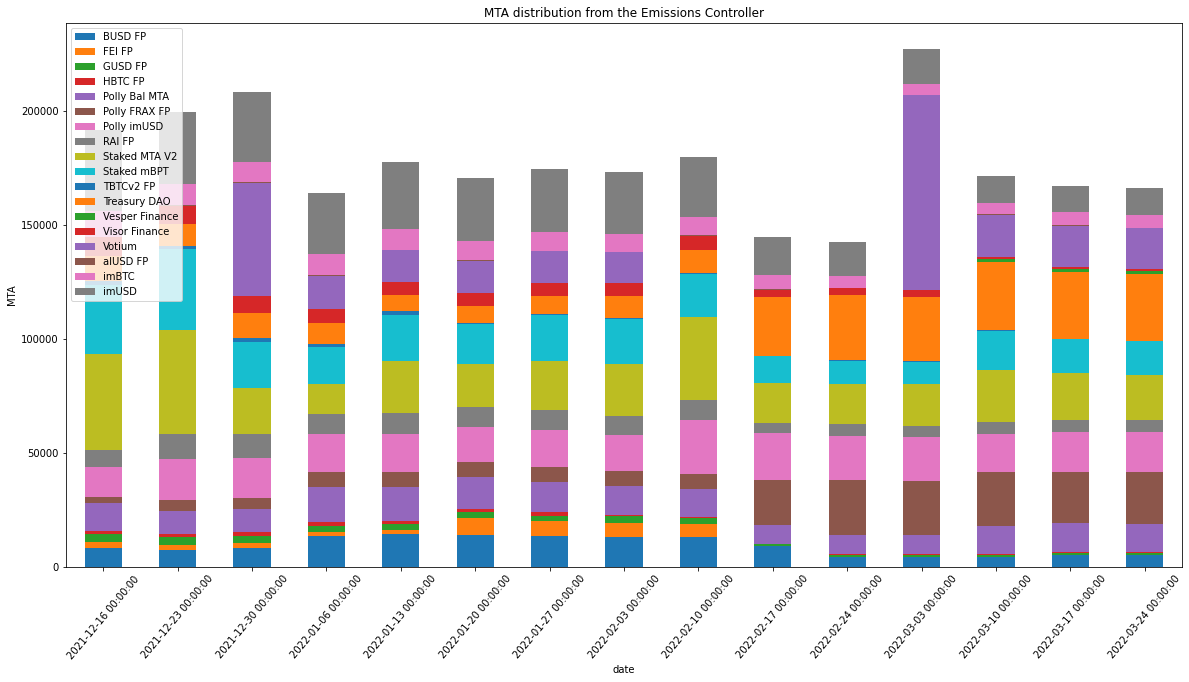

In [32]:
ax = dials_pivot.plot(kind='bar', stacked=True, figsize=(20,10),
               title="MTA distribution from the Emissions Controller", ylabel="MTA", rot=50).legend(loc='upper left')
plt.show()

### Cumulated MTA distributed by the Emissions Controller

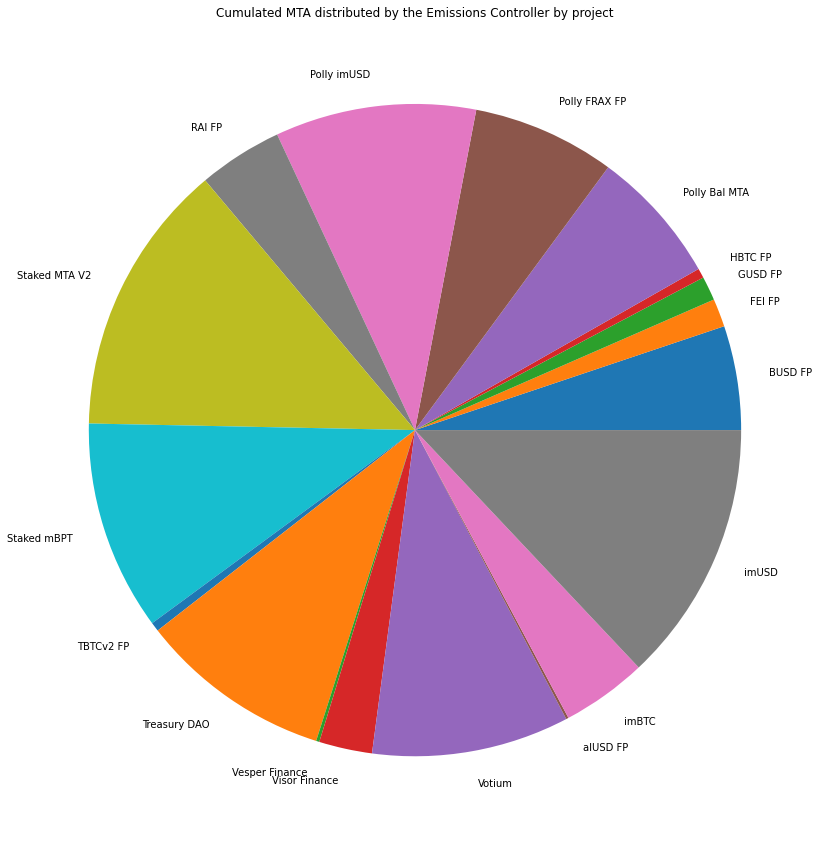

In [33]:
dials_pivot.cumsum().iloc[-1,:].plot(kind='pie', figsize=(15,15),
                              title="Cumulated MTA distributed by the Emissions Controller by project", ylabel='')
plt.show()

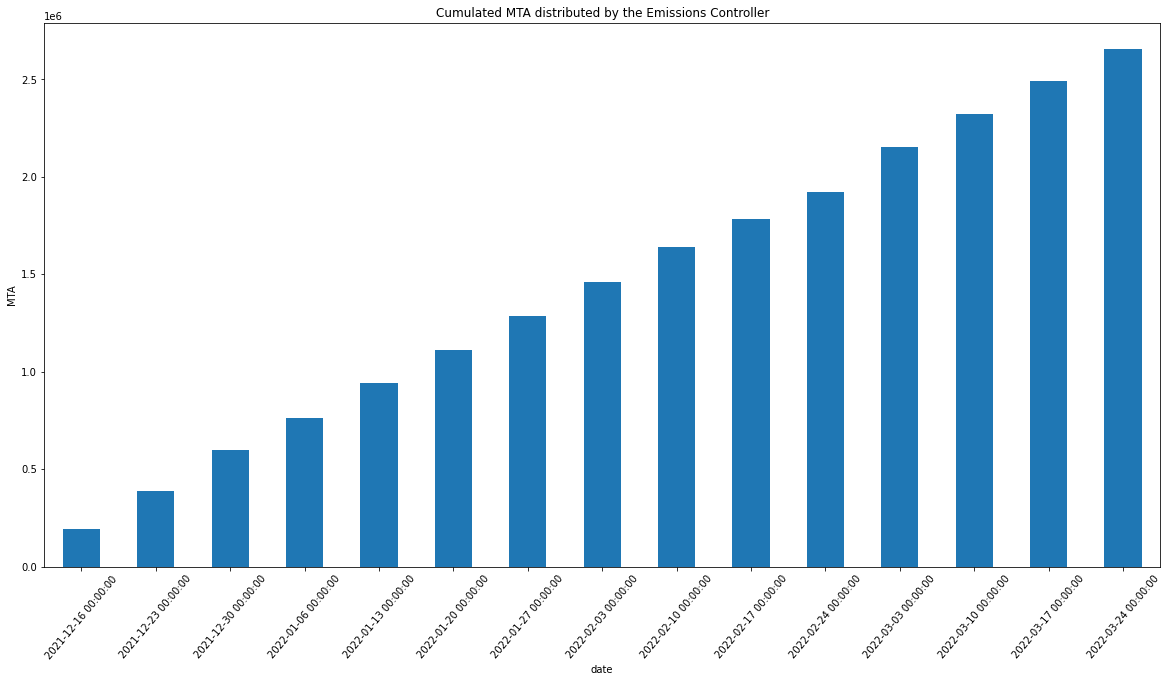

In [34]:
dials_pivot.cumsum().sum(axis=1).plot(kind='bar', figsize=(20,10), ylabel="MTA",
                               title="Cumulated MTA distributed by the Emissions Controller", rot=50)
plt.show()